In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import poisson
from astropy.table import QTable, Table, Column
from astropy import units as u
import openpyxl as pyxl
from os import path

Text(0.5, 1.0, 'e.coli/norfloxacin mutation rate')

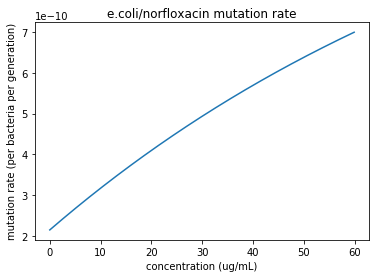

In [4]:
# MUTATION RATE
def mutation_rate(concentration):
    mu_basal = 2.15*10**-10 # basal mutation rate
    m = 6 # max fold increase in mutation rate
    h = 0.01 # steepness of curve
    return mu_basal + (1-np.exp(-h*concentration))*(m-1)*mu_basal
concentrations = np.arange(0,60,0.1)
mutation_rates = [mutation_rate(conc) for conc in concentrations]
plt.plot(concentrations,mutation_rates)
plt.xlabel("concentration (ug/mL)")
plt.ylabel("mutation rate (per bacteria per generation)")
plt.title("e.coli/norfloxacin mutation rate")



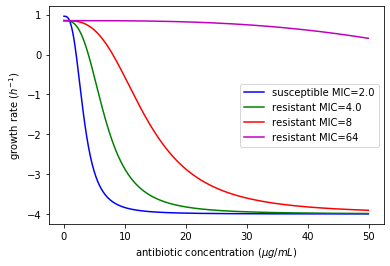

MSC = 0.9473055231097177
k = 3
min growth = -4
max growth susceptible = 0.96
max growth resistant = 0.85


In [5]:
#PARAMETERS FOR AMPICILLIN
MIC = 2.0 # ug/mL
MIC_r1 = 4.0 # ug/mL
MIC_r2 = 8
MIC_r3 = 64
k = 3
min_growth = -4
max_growth_s = 0.96
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.85

# k = ufloat(0.75, 0.19)
# min_growth = ufloat(-4.0, 0.8)
# max_growth = ufloat(0.75, 0.21)

def fitness_r1(c):
    return max_growth_r1 - (((max_growth_r1 - min_growth)*((c/MIC_r1)**k))/(((c/MIC_r1)**k)-(min_growth/max_growth_r1)))
def fitness_r2(c):
    return max_growth_r2 - (((max_growth_r2 - min_growth)*((c/MIC_r2)**k))/(((c/MIC_r2)**k)-(min_growth/max_growth_r2)))
def fitness_r3(c):
    return max_growth_r3 - (((max_growth_r3 - min_growth)*((c/MIC_r3)**k))/(((c/MIC_r3)**k)-(min_growth/max_growth_r3)))
def fitness_s(c):
    return max_growth_s - (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))

concentrations = np.arange(0,50,0.1)
growth_s = [fitness_s(c) for c in concentrations]
growth_r1 = [fitness_r1(c) for c in concentrations]
growth_r2 = [fitness_r2(c) for c in concentrations]
growth_r3 = [fitness_r3(c) for c in concentrations]

plt.figure()
plt.plot(concentrations,growth_s,label='susceptible MIC='+str(MIC) ,color='b')
plt.plot(concentrations,growth_r1,label='resistant MIC='+str(MIC_r1),color='g')
plt.plot(concentrations,growth_r2,label='resistant MIC='+str(MIC_r2),color='r')
plt.plot(concentrations,growth_r3,label='resistant MIC='+str(MIC_r3),color='m')
plt.legend()
plt.xlabel("antibiotic concentration $(\mu g/mL)$")
plt.ylabel("growth rate $(h^{-1})$")
plt.show()

sc = 1 - (max_growth_r1/max_growth_s)
a = 1+(max_growth_r1/-min_growth)
MSC = (sc/(a-(a*(1-sc)/(MIC_r1/MIC)**k)))**(1/k)
print("MSC =",MSC*MIC)

print("k =", k)
print("min growth =", min_growth)
print("max growth susceptible =", max_growth_s)
print("max growth resistant =", max_growth_r1)
# ideal for killing the resistant bacteria quickly is between the MIC and the threshold at which 
# tolerant bacteria become more fit than resistant
# propose a new window of concentrations for ideal killing of resistant bacteria
# for very high concentrations, can run simulations to determine the likelihood
# that tolerant bacteria give rise to resistant bacteria before the antibiotic degrades

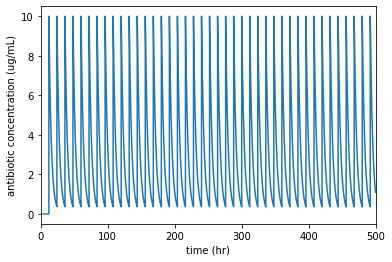

In [6]:
# CONSTANT ANTIBIOTIC CONCENTRATION CONSTANTS WITH PERSISTENCE
# PARAMETERS FOR AMPICILLIN/E.COLI
MIC = 2.0 # ug/mL
MIC_r1 = 4.0 # ug/mL
MIC_r2 = 8
MIC_r3 = 64
k = 0.75
min_growth = -3.5
max_growth_s = 0.96
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.75

# SIMULATION
T = 500
dt = 0.01
t = np.arange(0,T,dt)
r_initial = 0
s_initial = 10**5
t_initial = 0
p_initial = 0


#ANTIBIOTIC CONCENTRATION PARAMETERS
conc_max = 10 # ug/mL
conc_min = 1 # ug/mL
freq = 12 # hr
growth_period = 12

def conc(t):
    if t < growth_period:
            antibiotic_conc = 0
    else:
        n = t//freq
        decay_rate = -0.27726 #(1/freq)*np.log(conc_min/conc_max)
        antibiotic_conc = conc_max*np.exp(decay_rate*(t-(freq*n)))
    return(antibiotic_conc)

concentration = [conc(time) for time in t]
plt.figure()
plt.plot(t,concentration)
plt.xlabel("time (hr)")
plt.xlim(0,T)
plt.ylabel("antibiotic concentration (ug/mL)")
plt.show()

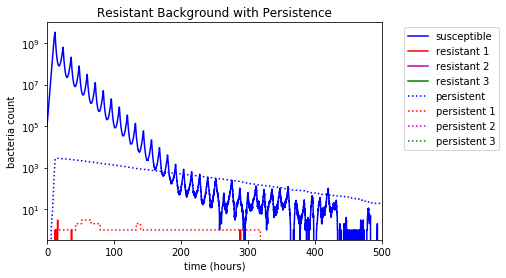

In [7]:
# TOLERANCE AND PERSISTENCE

r1 = [r_initial]*len(t)
r2 = [r_initial]*len(t)
r3 = [r_initial]*len(t)
s = [s_initial]*len(t)
ps = [p_initial]*len(t)
pr1 = [p_initial]*len(t)
pr2 = [p_initial]*len(t)
pr3 = [p_initial]*len(t)
weightedMICs = [0]*len(t)
weightedMaxGrowthRates = [0]*len(t)
totalr = [0]*len(t)
totalp = [0]*len(t)
t_lag = 0
K = 5*10**9
mean_sr = [0]*len(t)
mean_sp = [0]*len(t)
mean_ps = [0]*len(t)
mean_pr = [0]*len(t)
mu_sr1 = [0]*len(t)
mu_sr2 = [0]*len(t)
mu_sr3 = [0]*len(t)
mu_pr1 = [0]*len(t)
mu_pr2 = [0]*len(t)
mu_pr3 = [0]*len(t)
mu_sp = [0]*len(t)
mu_sp1 = [0]*len(t)
mu_sp2 = [0]*len(t)
mu_sp3 = [0]*len(t)
mu_ps = [0]*len(t)
mu_ps1 = [0]*len(t)
mu_ps2 = [0]*len(t)
mu_ps3 = [0]*len(t)
persistencemutfactor = 10**4
pgrate = 0.01
gprate = 0.000001
mu_basal = 2.15*10**-10

def growth_rate_r1(c):
    return max_growth_r1
def growth_rate_r2(c):
    return max_growth_r2
def growth_rate_r3(c):
    return max_growth_r3
def growth_rate_s(c):
    return max_growth_s 
def death_rate_r1(c):
    return (((max_growth_r1 - min_growth)*((c/MIC_r1)**k))/(((c/MIC_r1)**k)-(min_growth/max_growth_r1)))
def death_rate_r2(c):
    return (((max_growth_r2 - min_growth)*((c/MIC_r2)**k))/(((c/MIC_r2)**k)-(min_growth/max_growth_r2)))
def death_rate_r3(c):
    return (((max_growth_r3 - min_growth)*((c/MIC_r3)**k))/(((c/MIC_r3)**k)-(min_growth/max_growth_r3)))
def death_rate_s(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))
def mut_frequency(c):
    m = 5 # max fold increase in mutation rate
    h = 2.5 # steepness of curve
    return mu_basal + (1-np.exp(-h*c))*(m-1)*mu_basal
# the mutation frequency increases with antibiotic concentration, but 
# the number of susceptible bacteria also declines, so it's a tradeoff

def simulation_tp(seed):
    np.random.seed(seed)
    for i in range(len(t)-1):
    # 1/generation time
        g_r1 = growth_rate_r1(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r1 = death_rate_r1(conc(i*dt))
        g_r2 = growth_rate_r2(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r2 = death_rate_r2(conc(i*dt))
        g_r3 = growth_rate_r3(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r3 = death_rate_r3(conc(i*dt))
        g_s = growth_rate_s(conc(i*dt))
        d_s = death_rate_s(conc(i*dt))
        totalr[i] = r1[i] + r2[i] + r3[i] + pr1[i] + pr2[i] + pr3[i]
        totalp[i] = ps[i] + pr1[i] + pr2[i] + pr3[i]
        N = r1[i] + r2[i] + r3[i] + ps[i] + pr1[i] + pr2[i] + pr3[i] + s[i]
        totalMICs = s[i]+ps[i]
        totalMIC1 = r1[i]+pr1[i]
        totalMIC2 = r2[i]+pr2[i]
        totalMIC3 = r3[i]+pr3[i]
        totalronly = r1[i]+r2[i]+r3[i]
        totalTols = ps[i]+pr1[i]+pr2[i]+pr3[i]
        if N>0:
            weightedMIC = (totalMICs/N)*MIC + (totalMIC1/N)*MIC_r1 + (totalMIC2/N)*MIC_r2 + (totalMIC3/N)*MIC_r3
            weightedMaxGrowthRate = ((totalronly/N)*max_growth_r1 + (s[i]/N)*max_growth_s)
        else:
            weightedMIC = 0
            weightedMaxGrowthRate = 0
        weightedMICs[i] = weightedMIC
        weightedMaxGrowthRates[i] = weightedMaxGrowthRate
        mean_sr[i] = abs(dt*(mut_frequency(conc(i*dt)))*g_s*(1-N/K))
        
        mean_sp[i] = abs(dt*gprate*(N/K)) 
        mean_ps[i] = abs(dt*pgrate)
        mean_pr[i] = abs((persistencemutfactor)*dt*mut_frequency(conc(i*dt)))
        
        mu_sr1[i] = mean_sr[i]*s[i]
        mu_sr2[i] = mean_sr[i]*r1[i]
        mu_sr3[i] = mean_sr[i]*r2[i]
        
        mu_pr1[i] = mean_pr[i]*ps[i]
        mu_pr2[i] = mean_pr[i]*pr1[i]
        mu_pr3[i] = mean_pr[i]*pr2[i]
        mu_sp[i] = mean_sp[i]*s[i]
        mu_sp1[i] = mean_sp[i]*r1[i]
        mu_sp2[i] = mean_sp[i]*r2[i]
        mu_sp3[i] = mean_sp[i]*r3[i]
        mu_ps[i] = mean_ps[i]*ps[i]
        mu_ps1[i] = mean_ps[i]*pr1[i]
        mu_ps2[i] = mean_ps[i]*pr2[i]
        mu_ps3[i] = mean_ps[i]*pr3[i]
# change in population from regular growth
        if r1[i]*(1-(N/K))*(g_r1*dt) > 0: 
            if r1[i]*(1-(N/K))*(g_r1*dt) - d_r1*r1[i]*dt > -r1[i] and r1[i] >= 1: 
                r1[i+1] = (r1[i] + np.random.poisson(r1[i]*(1-(N/K))*(g_r1*dt)) - np.random.poisson(d_r1*r1[i]*dt))
            else:
                r1[i+1] = 0
        elif d_r1*r1[i]*dt > 0:
            r1[i+1] = r1[i] - np.random.poisson(d_r1*r1[i]*dt)
        else:
            r1[i+1] = r1[i]
        if r2[i]*(1-(N/K))*(g_r2*dt) > 0: 
            if r2[i]*(1-(N/K))*(g_r2*dt) - d_r2*r2[i]*dt > -r2[i] and r2[i] >= 1: 
                r2[i+1] = (r2[i] + np.random.poisson(r2[i]*(1-(N/K))*(g_r2*dt)) - np.random.poisson(d_r2*r2[i]*dt))
            else:
                r2[i+1] = 0
        elif d_r2*r2[i]*dt > 0:
            r2[i+1] = r2[i] - np.random.poisson(d_r2*r2[i]*dt)
        else:
            r2[i+1] = r2[i]
        if r3[i]*(1-(N/K))*(g_r3*dt) > 0: 
            if r3[i]*(1-(N/K))*(g_r3*dt) - d_r3*r3[i]*dt > -r3[i] and r3[i] >= 1: 
                r3[i+1] = (r3[i] + np.random.poisson(r3[i]*(1-(N/K))*(g_r3*dt)) - np.random.poisson(d_r3*r3[i]*dt))
            else:
                r3[i+1] = 0
        elif d_r3*r3[i]*dt > 0:
            r3[i+1] = r3[i] - np.random.poisson(d_r3*r3[i]*dt)
        else:
            r3[i+1] = r3[i]
        if s[i]*(1-(N/K))*(g_s*dt) > 0:
            if (np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))) > -s[i] and s[i] >= 1:
                s[i+1] = s[i] + np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))
            else:
                s[i+1] = 0
        elif d_s*s[i]*dt > 0:
            s[i+1] = s[i] - np.random.poisson(d_s*s[i]*dt)
        else:
            s[i+1] = s[i]
        ps[i+1] = ps[i] # no growth or death for persistent bacteria
        pr1[i+1] = pr1[i]
        pr2[i+1] = pr2[i]
        pr3[i+1] = pr3[i]
# change in population from mutations 
        try:
            s[i+1] += (np.random.poisson(mu_ps[i]))
        except: pass
        try:
            s[i+1] -= np.random.poisson(mu_sr1[i])
        except: pass
        try:
            s[i+1] -= np.random.poisson(mu_st[i])
        except: pass
        try:
            s[i+1] -= np.random.poisson(mu_sp[i])
        except: pass
        try:
            r1[i+1] += (np.random.poisson(mu_sr1[i]))
        except: pass
        try:
            r1[i+1] += np.random.poisson(mu_ps1[i])
        except: pass
        try:
            r1[i+1] -= np.random.poisson(mu_st1[i])
        except: pass
        try:
            r1[i+1] -= np.random.poisson(mu_sr2[i])
        except: pass
        try:
            r1[i+1] -= np.random.poisson(mu_sp1[i])
        except: pass
        try:
            r2[i+1] += (np.random.poisson(mu_sr2[i]))
        except: pass
        try:
            r2[i+1] += np.random.poisson(mu_ps2[i])
        except: pass
        try:
            r2[i+1] -= np.random.poisson(mu_st2[i])
        except: pass
        try:
            r2[i+1] -= np.random.poisson(mu_sr3[i])
        except: pass
        try: 
            r2[i+1] -= np.random.poisson(mu_sp2[i])
        except: pass
        try: 
            r3[i+1] += (np.random.poisson(mu_sr3[i]))
        except: pass
        try: 
            r3[i+1] += np.random.poisson(mu_ps3[i])
        except: pass
        try: 
            r3[i+1] -= np.random.poisson(mu_st3[i])
        except: pass
        try: 
            r3[i+1] -= np.random.poisson(mu_sp3[i])
        except: pass
        try:
            ps[i+1] += (np.random.poisson(mu_sp[i]))
        except: pass
        try:
            ps[i+1] -= np.random.poisson(mu_ps[i])
        except: pass
        try:
            ps[i+1] -= np.random.poisson(mu_pr1[i])
        except: pass
        try:
            pr1[i+1] += (np.random.poisson(mu_pr1[i]))
        except: pass
        try:
            pr1[i+1] += np.random.poisson(mu_sp1[i])
        except: pass
        try:
            pr1[i+1] -= np.random.poisson(mu_sp2[i])
        except: pass
        try:
            pr1[i+1] -= np.random.poisson(mu_ps1[i])
        except: pass
        try:
            pr2[i+1] += np.random.poisson(mu_pr2[i])
        except: pass
        try:
            pr2[i+1] += np.random.poisson(mu_sp2[i])
        except: pass
        try:
            pr2[i+1] -= np.random.poisson(mu_pr3[i])
        except: pass
        try:
            pr2[i+1] -= np.random.poisson(mu_ps2[i])
        except: pass
        try:
            pr3[i+1] += (np.random.poisson(mu_pr3[i]))
        except: pass
        try:
            pr3[i+1] += np.random.poisson(mu_sp3[i])
        except: pass
        try:
            pr3[i+1] -= np.random.poisson(mu_ps3[i])
        except: pass
        
# tolerant/persistent bacteria have been shown to have mutation rates 10^4 fold that of susceptible
# Levin Reisman paper showed that tolerance mutations are around 50 times more common than resistant

# solve model
simulation_tp(12)

# plot results
plt.figure()
# plt.plot(t,totalr,label="resistant")
plt.plot(t,s,label="susceptible",color='b',linestyle='solid')
plt.plot(t,r1,label="resistant 1",color='r',linestyle='solid')
plt.plot(t,r2,label="resistant 2",color='m',linestyle='solid')
plt.plot(t,r3,label="resistant 3",color='g',linestyle='solid')
# plt.plot(t,totalp,label="persistent")
plt.plot(t,ps,label="persistent",color='b',linestyle='dotted')
plt.plot(t,pr1,label="persistent 1",color='r',linestyle='dotted')
plt.plot(t,pr2,label="persistent 2",color='m',linestyle='dotted')
plt.plot(t,pr3,label="persistent 3",color='g',linestyle='dotted')
plt.xlabel('time (hours)')
plt.xlim(0,T)
plt.ylabel('bacteria count')
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05,1.0),loc='upper left')
plt.title("Resistant Background with Persistence")
plt.show()

In [15]:
def runAndSave(rawdatasheet, datasheet):
    wb_path = "rbiodata_rp10.xlsx"
    wb = load_workbook(wb_path)
    for run in range(100):
        send = 0
        r1start = 0
        r1end = 0
        r2start = 0
        r2end = 0
        r3start = 0
        r3end = 0
        
        simulation_tp(run)
        sheet = wb[rawdatasheet]
        print(sheet)
        for time in range(500):
            sheet.cell(row=(run*502)+time+2, column=1, value=run+1)
            sheet.cell(row=(run*502)+time+2, column=2, value=t[time*100])
            sheet.cell(row=(run*502)+time+2, column=3, value=s[time*100])
            if s[time*100]<10 and send==0:
                send = time
            sheet.cell(row=(run*502)+time+2, column=4, value=r1[time*100])
            if r1[time*100]>10 and r1start==0:
                r1start = time
            if r1[time*100]<10 and r1start!=0 and r1end==0:
                r1end = time
            sheet.cell(row=(run*502)+time+2, column=5, value=r2[time*100])
            if r2[time*100]>10 and r2start==0:
                r2start = time
            if r2[time*100]<10 and r2start!=0 and r2end==0:
                r2end = time
            sheet.cell(row=(run*502)+time+2, column=6, value=r3[time*100])
            if r3[time*100]>10 and r3start==0:
                r3start = time
            if r3[time*100]<10 and r3start!=0 and r3end==0:
                r3end = time
            
            sheet.cell(row=(run*502)+time+2, column=11, value=ps[time*100])
            sheet.cell(row=(run*502)+time+2, column=12, value=pr1[time*100])
            sheet.cell(row=(run*502)+time+2, column=13, value=pr2[time*100])
            sheet.cell(row=(run*502)+time+2, column=14, value=pr3[time*100])
            sheet.cell(row=(run*502)+time+2, column=15, value=weightedMICs[time*100])
            sheet.cell(row=(run*502)+time+2, column=17, value=weightedMaxGrowthRates[time*100])

        sheet = wb[datasheet]
        sheet.cell(row=run+2, column=1, value=run+1)
        sheet.cell(row=run+2, column=2, value=send)
        sheet.cell(row=run+2, column=3, value=r1start)
        sheet.cell(row=run+2, column=4, value=r1end)
        sheet.cell(row=run+2, column=5, value=r2start)
        sheet.cell(row=run+2, column=6, value=r2end)
        sheet.cell(row=run+2, column=7, value=r3start)
        sheet.cell(row=run+2, column=8, value=r3end)
        sheet.cell(row=run+2, column=17, value=sum(weightedMICs)/len(weightedMICs))
        sheet.cell(row=run+2, column=19, value=sum(weightedMaxGrowthRates)/len(weightedMaxGrowthRates))
        wb.save(wb_path)

In [16]:
def load_workbook(wb_path):
    if path.exists(wb_path):
        return pyxl.load_workbook(wb_path)
    else:
        return pyxl.Workbook()

def createDataSheets(run):
    wb_path = "rbiodata_rp10.xlsx"
    wb = load_workbook(wb_path)
    rawsheetname = run+" raw"
    wb.create_sheet(run)
    wb.create_sheet(rawsheetname)
    sheet = wb[rawsheetname]
    bacteriaTypes = [
        (1, "Simulation #"),
        (2, "Time"),
        (3, "Susceptible"),
        (4, "Resistant 1"),
        (5, "Resistant 2"),
        (6, "Resistant 3"),
        (11, "Persistent"),
        (12, "Persistent 1"),
        (13, "Persistent 2"),
        (14, "Persistent 3"),
        (15, "Weighted MIC"),
        (17, "Weighted Max Growth Rate (Fitness)")
    ]

    for col_idx, title in bacteriaTypes:
        sheet.cell(row=1, column=col_idx, value=title)

    sheet = wb[run]
    outputs = [
        (1, "Trial #"),
        (2, "S count > 10 end"),
        (3, "R1 count > 10 start"),
        (4, "R1 count > 10 end"),
        (5, "R2 count > 10 start"),
        (6, "R2 count > 10 end"),
        (7, "R3 count > 10 start"),
        (8, "R3 count > 10 start"),
        (17, "Weighted MIC"),
        (19, "Weighted Fitness")
    ]

    for col_idx, title in outputs:
        sheet.cell(row=1, column=col_idx, value=title)
        
    wb.save(wb_path)
    
# RP

# number = "1.1_pr"
# createDataSheets(number)
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.9
# MIC_r1 = 4.0 # ug/mL
# MIC_r2 = 8
# MIC_r3 = 64
# persistencemutfactor = 10**4
# mu_basal = 2.15*10**-10
# conc_max = 10
# runAndSave(number+" raw", number)

# number = "1.2_pr"
# createDataSheets(number)
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.85
# runAndSave(number+" raw", number)

# number = "1.3_pr"
# createDataSheets(number)
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.80
# runAndSave(number+" raw", number)

# number = "1.4_pr"
# createDataSheets(number)
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.75
# runAndSave(number+" raw", number)

# number = "1.5_pr"
# createDataSheets(number)
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.7
# runAndSave(number+" raw", number)

# RP1

# number = "1.6_pr"
# createDataSheets(number)
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.9
# MIC_r1 = 4.0 # ug/mL
# MIC_r2 = 8
# MIC_r3 = 64
# persistencemutfactor = 10**4
# mu_basal = 2.15*10**-10
# conc_max = 12
# runAndSave(number+" raw", number)

# number = "1.7_pr"
# createDataSheets(number)
# conc_max = 2
# runAndSave(number+" raw", number)

# number = "1.8_pr"
# createDataSheets(number)
# conc_max = 4
# runAndSave(number+" raw", number)

# number = "1.9_pr"
# createDataSheets(number)
# conc_max = 6
# runAndSave(number+" raw", number)

# number = "1.10_pr"
# createDataSheets(number)
# conc_max = 8
# runAndSave(number+" raw", number)

# RP2

# number = "1.11_pr"
# createDataSheets(number)
# conc_max = 14
# runAndSave(number+" raw", number)

# number = "1.12_pr"
# createDataSheets(number)
# conc_max = 16
# runAndSave(number+" raw", number)

# number = "1.13_pr"
# createDataSheets(number)
# conc_max = 18
# runAndSave(number+" raw", number)

# number = "1.14_pr"
# createDataSheets(number)
# conc_max = 20
# runAndSave(number+" raw", number)

# RP5

# number = "1.15_pr"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 16
# runAndSave(number+" raw", number)

# number = "1.16_pr"
# createDataSheets(number)
# MIC_r2 = 24
# runAndSave(number+" raw", number)

# number = "1.17_pr"
# createDataSheets(number)
# MIC_r2 = 32
# runAndSave(number+" raw", number)

# number = "1.18_pr"
# createDataSheets(number)
# MIC_r2 = 40
# runAndSave(number+" raw", number)

# number = "1.19_pr"
# createDataSheets(number)
# MIC_r2 = 48
# runAndSave(number+" raw", number)

# RP4

# number = "1.20"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 12
# runAndSave(number+" raw", number)

# number = "1.21"
# createDataSheets(number)
# MIC_r2 = 20
# runAndSave(number+" raw", number)

# number = "1.22"
# createDataSheets(number)
# MIC_r2 = 28
# runAndSave(number+" raw", number)

# number = "1.23"
# createDataSheets(number)
# MIC_r2 = 36
# runAndSave(number+" raw", number)

# number = "1.24"
# createDataSheets(number)
# MIC_r2 = 44
# runAndSave(number+" raw", number)

# number = "1.25"
# createDataSheets(number)
# MIC_r2 = 52
# runAndSave(number+" raw", number)

# number = "1.26"
# createDataSheets(number)
# MIC_r2 = 56
# runAndSave(number+" raw", number)

# number = "1.27"
# createDataSheets(number)
# MIC_r2 = 60
# runAndSave(number+" raw", number)

# RP6

# number = "1.7_pr"
# createDataSheets(number)
# conc_max = 2
# runAndSave(number+" raw", number)

# number = "1.8_pr"
# createDataSheets(number)
# conc_max = 4
# runAndSave(number+" raw", number)

# number = "1.9_pr"
# createDataSheets(number)
# conc_max = 6
# runAndSave(number+" raw", number)

# number = "1.10_pr"
# createDataSheets(number)
# conc_max = 8
# runAndSave(number+" raw", number)

# RP7

# number = "1.20_pr"
# createDataSheets(number)
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.8
# MIC_r1 = 4.0 # ug/mL
# MIC_r2 = 8
# MIC_r3 = 64
# tolerancemutfactor = 10**4
# mu_basal = 2.15*10**-10
# conc_max = 0
# MDK = 8
# runAndSave(number+" raw", number)

# number = "1.21_pr"
# createDataSheets(number)
# conc_max = 1
# runAndSave(number+" raw", number)

# number = "1.22_pr"
# createDataSheets(number)
# conc_max = 3
# runAndSave(number+" raw", number)

# number = "1.23_pr"
# createDataSheets(number)
# conc_max = 5
# runAndSave(number+" raw", number)

# number = "1.24_pr"
# createDataSheets(number)
# conc_max = 7
# runAndSave(number+" raw", number)

# RP8

# number = "1.25_pr"
# createDataSheets(number)
# conc_max = 9
# runAndSave(number+" raw", number)

# number = "1.26_pr"
# createDataSheets(number)
# conc_max = 11
# runAndSave(number+" raw", number)

# number = "1.27_pr"
# createDataSheets(number)
# conc_max = 13
# runAndSave(number+" raw", number)

# number = "1.28_pr"
# createDataSheets(number)
# conc_max = 15
# runAndSave(number+" raw", number)

# number = "1.29_pr"
# createDataSheets(number)
# conc_max = 17
# runAndSave(number+" raw", number)

# number = "1.30_pr"
# createDataSheets(number)
# conc_max = 19
# runAndSave(number+" raw", number)

# RP9

# number = "1.28_pr"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 8
# persistencemutfactor = 10**2
# runAndSave(number+" raw", number)

# number = "1.29_pr"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 8
# persistencemutfactor = 10**3
# runAndSave(number+" raw", number)

# number = "1.30_pr"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 8
# persistencemutfactor = 10**4
# runAndSave(number+" raw", number)

# number = "1.31_pr"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 8
# persistencemutfactor = 10**5
# runAndSave(number+" raw", number)

# number = "1.32_pr"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 8
# persistencemutfactor = 10**6
# runAndSave(number+" raw", number)

# RP10

number = "1.33_pr"
createDataSheets(number)
persistencemutfactor = 10**4
stmutfactor = 50
gprate = 0.00001
runAndSave(number+" raw", number)

number = "1.34_pr"
createDataSheets(number)
persistencemutfactor = 10**4
gprate = 0.0001
runAndSave(number+" raw", number)

number = "1.35_pr"
createDataSheets(number)
persistencemutfactor = 10**4
gprate = 0.001
runAndSave(number+" raw", number)

number = "1.36_pr"
createDataSheets(number)
persistencemutfactor = 10**4
gprate = 0.01
runAndSave(number+" raw", number)



<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "1.33_pr raw">
<Worksheet "

<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "1.36_pr raw">
<Worksheet "

In [ ]:
time = 500
dtime = 1
times = np.arange(0,time,dtime)
weightedMICs = []
weightedMDKs = []
def present_probability_rtp(runs,time,dtime):
    scounts = [0]*int(time/dtime)
    r1counts = [0]*int(time/dtime)
    r2counts = [0]*int(time/dtime)
    r3counts = [0]*int(time/dtime)
    tolcounts = [0]*int(time/dtime)
    tolr1counts = [0]*int(time/dtime)
    tolr2counts = [0]*int(time/dtime)
    tolr3counts = [0]*int(time/dtime)
    pscounts = [0]*int(time/dtime)
    pr1counts = [0]*int(time/dtime)
    pr2counts = [0]*int(time/dtime)
    pr3counts = [0]*int(time/dtime)
    for q in range(runs):
        simulation_tp(q)
        for i in range(int(time/dtime)):
            if s[100*dtime*i] > 10:
                scounts[i] += 1
            if r1[100*dtime*i] > 10:
                r1counts[i] += 1
            if r2[100*dtime*i] > 10:
                r2counts[i] += 1
            if r3[100*dtime*i] > 10:
                r3counts[i] += 1
            if tol[100*dtime*i] > 10:
                tolcounts[i] += 1
            if tolr1[100*dtime*i] > 10:
                tolr1counts[i] += 1
            if tolr2[100*dtime*i] > 10:
                tolr2counts[i] += 1
            if tolr3[100*dtime*i] > 10:
                tolr3counts[i] += 1
            if ps[100*dtime*i] > 10:
                pscounts[i] += 1
            if pr1[100*dtime*i] > 10:
                pr1counts[i] += 1
            if pr2[100*dtime*i] > 10:
                pr2counts[i] += 1
            if pr3[100*dtime*i] > 10:
                pr3counts[i] += 1
        totalBacteria = s[-1]+tol[-1]+ps[-1]+r1[-1]+tolr1[-1]+pr1[-1]+r2[-1]+tolr2[-1]+pr2[-1]+r3[-1]+tolr3[-1]+pr3[-1]
        totalMICs = s[-1]+tol[-1]+ps[-1]
        totalMIC1 = r1[-1]+tolr1[-1]+pr1[-1]
        totalMIC2 = r2[-1]+tolr2[-1]+pr2[-1]
        totalMIC3 = r3[-1]+tolr3[-1]+pr3[-1]
        weightedMIC = (totalMICs/totalBacteria)*MIC + (totalMIC1/totalBacteria)*MIC_r1 + (totalMIC2/totalBacteria)*MIC_r2 + (totalMIC3/totalBacteria)*MIC_r3
        weightedMDK = ((tol[-1]+tolr1[-1]+tolr2[-1]+tolr3[-1])/totalBacteria)*MDK + (totalBacteria-(tol[-1]+tolr1[-1]+tolr2[-1]+tolr3[-1]))/totalBacteria



In [ ]:
weightedMICsList = []
weightedMDKsList = []
sendsList = []
r1startsList = []
r1endsList = []
r2startsList = []
r2endsList = []
r3startsList = []
r3endsList = []
tolstartsList = []
tolendsList = []
tolr1startsList = []
tolr1endsList = []
tolr2startsList = []
tolr2endsList = []
tolr3startsList = []
tolr3endsList = []

half = 50
def showAndSave():
    times = np.arange(0,time,dtime)
    plt.figure()
    plt.scatter(times,scounts,label="susceptible")
    plt.scatter(times,r1counts,label="resistant 1")
    plt.scatter(times,r2counts,label="resistant 2")
    plt.scatter(times,r3counts,label="resistant 3")
    plt.xlabel("time (hours)")
    plt.ylabel("% probability of fixation")
    plt.legend()
    plt.show()

    sstart = 0
    send = 0
    r1start = 0
    r1end = 0
    r2start = 0
    r2end = 0
    r3start = 0
    r3end = 0

    for i in range(sstart, len(scounts)):
        if scounts[i] < half:
            send = i
            print("The susceptible bacteria are no longer present at ", send, "hours")
            sendsList.append(send)
            break
    if send == 0:
        print("The susceptible bacteria are present to the end of the treatment.")
        sendsList.append(500)


    for i in range(len(r1counts)):
        if r1counts[i] > half:
            r1start = i
            r1startsList.append(r1start)
            break
    if r1start > 0:
        for i in range(r1start, len(r1counts)):
            if r1counts[i] < half:
                r1end = i
                r1endsList.append(r1end)
                print("The first resistant bacteria are present between", r1start, "and", r1end, "hours")
                break
    if r1start == 0:
        r1startsList.append(0)
        r1endsList.append(0)
        print("The first resistant bacteria never appear")
    elif r1end == 0:
        r1endsList.append(500)
        print("The first resistant bacteria are present from", r1start, "hours to the end of the treatment.")

    for i in range(len(r2counts)):
        if r2counts[i] > half:
            r2start = i
            r2startsList.append(r2start)
            break
    if r2start > 0:
        for i in range(r2start, len(r2counts)):
            if r2counts[i] < half:
                r2end = i
                r2endsList.append(r2end)
                print("The second resistant bacteria are present between", r2start, "and", r2end, "hours")
                break
    if r2start == 0:
        r2startsList.append(0)
        r2endsList.append(0)
        print("The second resistant bacteria never appear")
    elif r2end == 0:
        r2endsList.append(500)
        print("The second resistant bacteria are present from", r2start, "hours to the end of the treatment.")


    for i in range(len(r3counts)):
        if r3counts[i] > half:
            r3start = i
            r3startsList.append(r3start)
            break
    if r3start > 0:
        for i in range(r3start, len(r3counts)):
            if r3counts[i] < half:
                r3end = i
                r3endsList.append(r3end)
                print("The third resistant bacteria are present between", r3start, "and", r3end, "hours")
                break
    if r3start == 0:
        r3startsList.append(0)
        r3endsList.append(0)
        print("The third resistant bacteria never appear")
    elif r3end == 0:
        r3endsList.append(500)
        print("The third resistant bacteria are present from", r3start, "hours to the end of the treatment.")

    plt.figure()
    plt.scatter(times,tolcounts,label="tolerant")
    plt.scatter(times,tolr1counts,label="tolerant 1")
    plt.scatter(times,tolr2counts,label="tolerant 2")
    plt.scatter(times,tolr3counts,label="tolerant 3")
    plt.xlabel("time (hours)")
    plt.ylabel("% probability of fixation")
    plt.legend()
    plt.show() 

    tolstart = 0
    tolend = 0
    tolr1start = 0
    tolr1end = 0
    tolr2start = 0
    tolr2end = 0
    tolr3start = 0
    tolr3end = 0

    for i in range(len(tolcounts)):
        if tolcounts[i] > half:
            tolstart = i
            tolstartsList.append(tolstart)
            break
    if tolstart > 0:
        for i in range(tolstart, len(tolcounts)):
            if tolcounts[i] < half:
                tolend = i
                tolendsList.append(tolend)
                print("The susceptible tolerant bacteria are present between", tolstart, "and", tolend, "hours")
                break
    if tolstart == 0:
        tolstartsList.append(0)
        tolendsList.append(0)
        print("The susceptible tolerant bacteria never appear")
    elif tolend == 0:
        tolendsList.append(500)
        print("The susceptible tolerant bacteria are present from", tolstart, "hours to the end of the treatment.")


    for i in range(len(tolr1counts)):
        if tolr1counts[i] > half:
            tolr1start = i
            tolr1startsList.append(tolr1start)
            break
    if tolr1start > 0:
        for i in range(tolr1start, len(tolr1counts)):
            if tolr1counts[i] < half:
                tolr1end = i
                tolr1endsList.append(tolr1end)
                print("The first tolerant bacteria are present between", tolr1start, "and", tolr1end, "hours")
                break
    if tolr1start == 0:
        tolr1startsList.append(tolr1start)
        tolr1endsList.append(tolr1end)
        print("The first tolerant bacteria never appear")
    elif tolr1end == 0:
        tolr1endsList.append(500)
        print("The first tolerant bacteria are present from", tolr1start, "hours to the end of the treatment.")

    for i in range(len(tolr2counts)):
        if tolr2counts[i] > half:
            tolr2start = i
            tolr2startsList.append(tolr2start)
            break
    if tolr2start > 0:
        for i in range(tolr2start, len(tolr2counts)):
            if tolr2counts[i] < half:
                tolr2end = i
                tolr2endsList.append(tolr2end)
                print("The second tolerant bacteria are present between", tolr2start, "and", tolr2end, "hours")
                break
    if tolr2start == 0:
        tolr2startsList.append(0)
        tolr2endsList.append(0)
        print("The second tolerant bacteria never appear")
    elif tolr2end == 0:
        tolr2endsList.append(500)
        print("The second tolerant bacteria are present from", tolr2start, "hours to the end of the treatment.")


    for i in range(len(tolr3counts)):
        if tolr3counts[i] > half:
            tolr3start = i
            tolr3startsList.append(tolr3start)
            break
    if tolr3start > 0:
        for i in range(tolr3start, len(tolr3counts)):
            if tolr3counts[i] < half:
                tolr3end = i
                tolr3endsList.append(tolr3end)
                print("The third tolerant bacteria are present between", tolr3start, "and", tolr3end, "hours")
                break
    if tolr3start == 0:
        tolr3startsList.append(0)
        tolr3endsList.append(0)
        print("The third tolerant bacteria never appear")
    elif tolr3end == 0:
        tolr3endsList.append(500)
        print("The third tolerant bacteria are present from", tolr3start, "hours to the end of the treatment.")

    wMIC = sum(weightedMICs)/len(weightedMICs)
    wMDK = sum(weightedMDKs)/len(weightedMDKs)
    weightedMICsList.append(wMIC)
    weightedMDKsList.append(wMDK)
    print("Average weighted MIC = ", wMIC)
    print("Average weighted MDK = ", wMDK)

In [ ]:
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.8
tolerancemutfactor = 10**5
present_probability_rtp(100,time,dtime)
showAndSave()

tolerancemutfactor = 10**4
present_probability_rtp(100,time,dtime)
showAndSave()

tolerancemutfactor = 10**3
present_probability_rtp(100,time,dtime)
showAndSave()

tolerancemutfactor = 10**2
present_probability_rtp(100,time,dtime)
showAndSave()


In [ ]:
toleranceMutFactors = [10**5, 10**4, 10**3, 10**2]
print("MICs = ", weightedMICsList)
print("MDKs = ", weightedMDKsList)
print("susceptible ends = ", sendsList)
print("r1starts =", r1startsList)
print("r1ends =", r1endsList)
print("r2starts =", r2startsList)
print("r2ends =", r2endsList)
print("r3starts =", r3startsList)
print("r3ends =", r3endsList)
print("tolstarts =", tolstartsList)
print("tolends =", tolendsList)
print("tolr1starts =", tolr1startsList)
print("tolr1ends =", tolr1endsList)
print("tolr2starts =", tolr2startsList)
print("tolr2ends =", tolr2endsList)
print("tolr3starts =", tolr3startsList)
print("tolr3ends =", tolr3endsList)
t = Table([toleranceMutFactors, weightedMICsList, weightedMDKsList, sendsList, r1startsList, r1endsList, r2startsList, r2endsList, r3startsList, r3endsList, tolstartsList, tolendsList, tolr1startsList, tolr1endsList, tolr2startsList, tolr2endsList, tolr3startsList, tolr3endsList], names=("mutation rates", "weighted MIC", "weighted MDK", "S end", "r1 start", "r1 end", "r2 start", "r2 end", "r3 start", "r3 end", "tol start", "tol end", "tolr1 start", "tolr1 end", "tolr2 start", "tolr2 end", "tolr3 start", "tolr3 end"))
t

In [ ]:


wb.save(wb_path)